# GAN (Generative adversarial Networks) digitos escritos.

## Librerias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

- Disponibilidad CUDA GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset MNIST

- Parametros

In [3]:
latent_dim = 100  # Dimensión del espacio latente (ruido de entrada)
batch_size = 64
epochs = 50
learning_rate = 0.0002

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar imágenes entre -1 y 1
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Imagenes reales del dataset MNIST

In [5]:
def plot_real_images(images, num_images=16, save_path=None):
    
    images = (images + 1) / 2  # rango [0, 1]

    grid_img = vutils.make_grid(images[:num_images], nrow=4, normalize=True, scale_each=True)

    plt.figure(figsize=(4, 4))
    plt.imshow(grid_img.permute(1, 2, 0).cpu())  # Convertir a formato de imagen (H, W, C)
    plt.axis('off')

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Asegurarse de que la carpeta exista
        plt.savefig(save_path)
        print(f"Imagen guardada en: {save_path}")
    else:
        plt.show()

    plt.close()

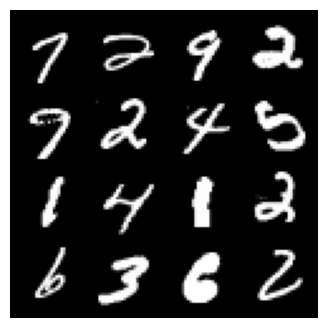

In [6]:
# Mostrar imágenes reales
data_iter = iter(train_loader)
real_images, _ = next(data_iter)
plot_real_images(real_images)

## Modelo

- Generador

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 28 * 28),
            nn.Tanh()  # Salida entre -1 y 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

- Discriminador

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Salida entre 0 y 1 (probabilidad)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

- Compilador

In [9]:
generator = Generator(latent_dim).to('cuda')
discriminator = Discriminator().to('cuda')

- Optimizadores

In [10]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

- Función de perdida

In [11]:
criterion = nn.BCELoss()

- Inicializar listas para almacenar pérdidas

In [12]:
losses_G = []
losses_D = []

- Crear directorio para guardar imágenes generadas

In [13]:
os.makedirs("generated_images", exist_ok=True)

## Entrenamiento

In [14]:
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Mover imágenes y etiquetas al dispositivo
        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        # Entrenar el Discriminador con imágenes reales
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_images), real_labels)

        # Generar imágenes falsas
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Entrenar el Discriminador con imágenes falsas
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Entrenar el Generador
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_images), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Almacenar pérdidas
        losses_D.append(d_loss.item())
        losses_G.append(g_loss.item())

        # Mostrar progreso cada 100 batches
        if i % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Batch [{i}/{len(train_loader)}], '
                  f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

    # Guardar y mostrar imágenes generadas cada 10 épocas
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            generated_images = generator(z)
            save_path = f"generated_images/epoch_{epoch+1}.png"
            plot_real_images(generated_images, save_path=save_path)

Epoch [0/50], Batch [0/938], D_loss: 1.3685, G_loss: 0.6683
Epoch [0/50], Batch [100/938], D_loss: 0.9496, G_loss: 0.7439
Epoch [0/50], Batch [200/938], D_loss: 0.6729, G_loss: 1.5285
Epoch [0/50], Batch [300/938], D_loss: 0.5310, G_loss: 1.9979
Epoch [0/50], Batch [400/938], D_loss: 0.1521, G_loss: 3.6025
Epoch [0/50], Batch [500/938], D_loss: 6.9699, G_loss: 0.5746
Epoch [0/50], Batch [600/938], D_loss: 0.7132, G_loss: 3.1089
Epoch [0/50], Batch [700/938], D_loss: 0.1431, G_loss: 3.0570
Epoch [0/50], Batch [800/938], D_loss: 0.7783, G_loss: 1.8336
Epoch [0/50], Batch [900/938], D_loss: 0.9410, G_loss: 2.0442
Epoch [1/50], Batch [0/938], D_loss: 0.5287, G_loss: 2.5513
Epoch [1/50], Batch [100/938], D_loss: 0.3151, G_loss: 2.6419
Epoch [1/50], Batch [200/938], D_loss: 1.0380, G_loss: 1.9425
Epoch [1/50], Batch [300/938], D_loss: 1.9758, G_loss: 1.0739
Epoch [1/50], Batch [400/938], D_loss: 1.9537, G_loss: 1.8919
Epoch [1/50], Batch [500/938], D_loss: 0.3650, G_loss: 3.0951
Epoch [1/50]

## Resultados.

Imagen guardada en: generated_images/final_result.png


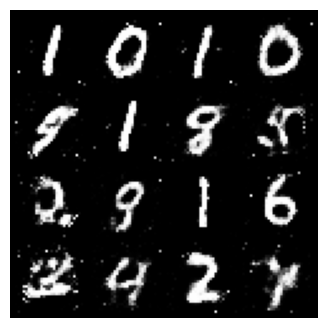

In [22]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    final_images = generator(z)
    save_path = f"generated_images/final_result.png"
    plot_real_images(final_images, save_path=save_path)
    plot_real_images(final_images)

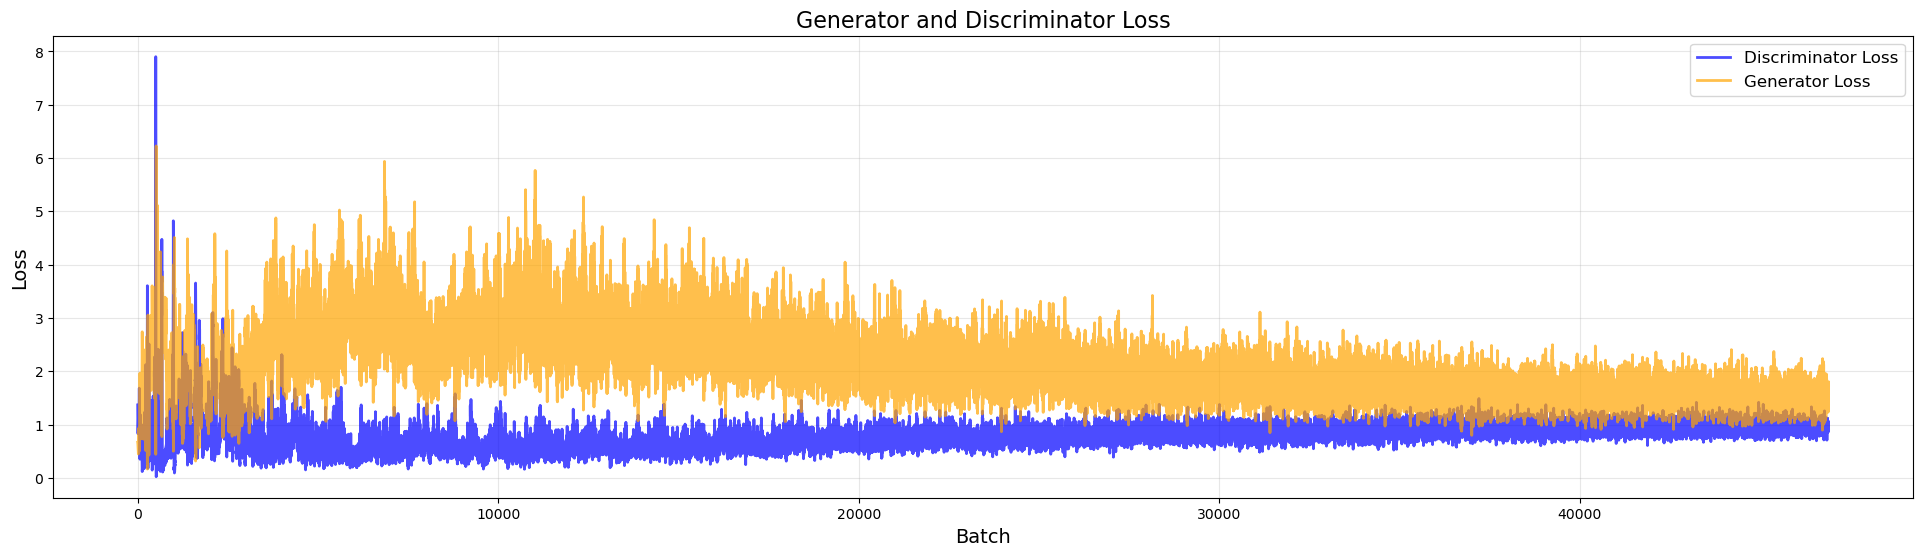

In [21]:
# Graficar pérdidas
plt.figure(figsize=(24, 6))  # Ajustar el tamaño de la figura
plt.plot(losses_D, label="Discriminator Loss", color="blue", alpha=0.7, linewidth=2)
plt.plot(losses_G, label="Generator Loss", color="orange", alpha=0.7, linewidth=2)

# Añadir etiquetas y título
plt.xlabel("Batch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Generator and Discriminator Loss", fontsize=16)

# Añadir leyenda y cuadrícula
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Guardar y mostrar
plt.savefig("generated_images/loss_plot.png", dpi=300, bbox_inches="tight")  # Guardar con mayor calidad
plt.show()